# Traitement images

### 1. Importation et préparation des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
import time
import shutil

2024-09-24 15:56:21.508960: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

Séparation de la colonne product_category_tree pour ne retenir que le premier niveau de classification

In [3]:
data['Category_Level_1'] = data['product_category_tree'].str.split('>>', expand=True)[0]

data['Category_Level_1'] = data['Category_Level_1'].str.replace('["', '', regex=False)

In [4]:
columns_of_interest= ['Category_Level_1', 'image']
df = data[columns_of_interest]
le = preprocessing.LabelEncoder()
df["label"] = le.fit_transform(df["Category_Level_1"])

/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_38162/1101903906.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"] = le.fit_transform(df["Category_Level_1"])


In [5]:
df.groupby("Category_Level_1").count()

,image,label
Category_Level_1,,
Baby Care,150,150
Beauty and Personal Care,150,150
Computers,150,150
Home Decor & Festive Needs,150,150
Home Furnishing,150,150
Kitchen & Dining,150,150
Watches,150,150


In [6]:
image_folder = '/Users/amira/Documents/OPC/Projet6/Images/'

list_photos = [os.path.join(image_folder, img_name) for img_name in df['image']]
print(len(list_photos))

1050


In [7]:
df['image_path'] = image_folder + df['image']

/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_38162/426650416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_path'] = image_folder + df['image']


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Category_Level_1  1050 non-null   object
 1   image             1050 non-null   object
 2   label             1050 non-null   int64 
 3   image_path        1050 non-null   object
dtypes: int64(1), object(3)
memory usage: 32.9+ KB


In [9]:
list_labels = df['label'].unique().tolist()
list_categories = df['Category_Level_1'].unique().tolist()

Division du jeu de données en train/test

In [10]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

print(f"Taille du train: {df_train.shape}")
print(f"Taille du test: {df_test.shape}")

Taille du train: (840, 4)
Taille du test: (210, 4)


In [11]:
train_folder = '/Users/amira/Documents/OPC/Projet6/Images/train_images/'
test_folder = '/Users/amira/Documents/OPC/Projet6/Images/test_images/'

### 2. Classification supervisée par approche simple

#### 2.1. Importation du modèle

- Importation du modèle pré-entraîné VGG16
- Gel des couches du modèle 
- Ajout de couches personnalisées
- Compilation du modèle

In [12]:
def create_model_fct() :
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    for layer in model0.layers:
        layer.trainable = False

    x = model0.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    model = Model(inputs=model0.input, outputs=predictions)
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

#### 2.2. Prétraitement des images

In [13]:
def image_prep_fct(df):
    prepared_images = []
    for image_num in range(len(df['image_path'])):
        img = load_img(df['image_path'].iloc[image_num], target_size=(224, 224))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
    prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np_train = image_prep_fct(df_train)
print(f"Shape des images d'entraînement : {images_np_train.shape}")

images_np_test = image_prep_fct(df_test)
print(f"Shape des images de test : {images_np_test.shape}")

Shape des images d'entraînement : (840, 224, 224, 3)


/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Shape des images de test : (210, 224, 224, 3)


In [14]:
X = images_np_train
y = to_categorical(df_train['label'])

X_test = images_np_test
y_test = to_categorical(df_test['label'])

y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

#### 2.3. Séparation du dataset

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(630, 224, 224, 3)

#### 2.4. Entraînement du modèle 

In [16]:
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

model1_save_path1 = "./model1_best_weights.keras"  
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [17]:
results_time = pd.DataFrame(columns=['Méthode', 'Temps exécution'])

In [18]:
start_time = time.time()

with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=10, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)
    

end_time = time.time()  
execution_time_1 = end_time - start_time
results_time = results_time.append({'Méthode': 'Approche simple', 'Temps exécution': execution_time_1}, ignore_index=True)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.2594 - loss: 9.2735 
Epoch 1: val_loss improved from inf to 1.68920, saving model to ./model1_best_weights.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 300s 30s/step - accuracy: 0.2719 - loss: 8.9990 - val_accuracy: 0.6905 - val_loss: 1.6892
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.6308 - loss: 2.1789 
Epoch 2: val_loss improved from 1.68920 to 1.17696, saving model to ./model1_best_weights.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 275s 28s/step - accuracy: 0.6327 - loss: 2.1690 - val_accuracy: 0.7524 - val_loss: 1.1770
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.7584 - loss: 1.3212 
Epoch 3: val_loss improved from 1.17696 to 1.07626, saving model to ./model1_best_weights.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 273s 28s/step - accuracy: 0.7569 - loss: 1.3393 - val_accuracy: 0.7619 - val_loss: 1.0763
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.7846 - loss: 0.9955 
Epoch 4: val_loss improve

/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_38162/1631289951.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_time = results_time.append({'Méthode': 'Approche simple', 'Temps exécution': execution_time_1}, ignore_index=True)


#### 2.5. Scores 

In [19]:
#Score du dernier epoch
loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 204s 10s/step - accuracy: 1.0000 - loss: 0.0180
Training Accuracy: 1.0000

7/7 ━━━━━━━━━━━━━━━━━━━━ 69s 10s/step - accuracy: 0.8136 - loss: 0.9556
Validation Accuracy:  0.8190


In [20]:
# Score de l'epoch optimal
model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

Test Accuracy       :  0.8000
Validation Accuracy :  0.8095


In [21]:
results_accuracy = pd.DataFrame(columns=['Méthode', 'Accuracy'])

In [22]:
results_accuracy = results_accuracy.append({'Méthode': 'Approche simple', 'Accuracy': accuracy}, ignore_index=True)

/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_38162/2643117895.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_accuracy = results_accuracy.append({'Méthode': 'Approche simple', 'Accuracy': accuracy}, ignore_index=True)


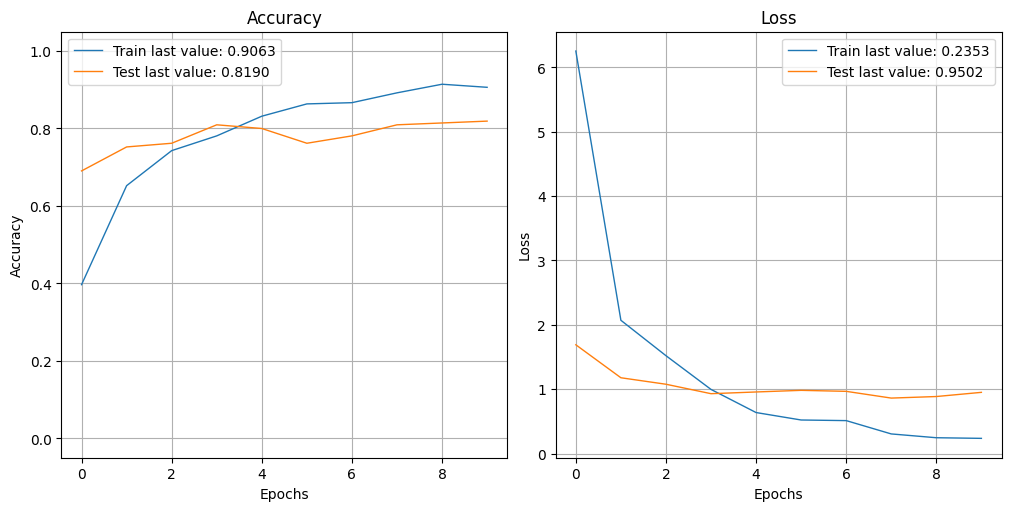

In [23]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard_1.png")
plt.close()

In [24]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 67s 9s/step
[3 6 2 6 3 5 4 0 0 2 6 0 1 5 6 3 1 1 6 0 1 2 6 3 3 0 4 4 2 0 2 4 6 5 0 6 4
 5 1 1 5 6 1 0 6 6 5 0 4 1 5 4 5 0 2 6 5 5 1 4 4 5 3 6 3 3 6 0 3 5 3 2 5 3
 3 3 2 6 1 5 3 4 2 0 3 5 2 5 3 4 3 4 6 1 2 5 0 4 6 3 5 1 1 5 3 1 1 1 2 2 3
 5 4 2 5 4 2 6 0 2 0 3 2 4 5 3 1 3 3 0 0 4 2 1 6 1 1 4 2 1 2 6 3 6 5 1 1 6
 6 0 0 5 3 4 3 3 5 1 3 1 4 5 6 5 0 4 0 6 1 0 4 0 2 1 4 0 2 4 0 5 2 4 0 1 0
 5 2 4 0 2 2 1 6 1 4 2 4 3 1 1 6 2 0 6 0 4 0 6 5 5]

[3 6 4 6 3 6 4 0 5 2 6 0 1 5 3 3 1 1 6 5 1 2 6 3 3 0 4 4 1 0 2 4 6 5 2 6 0
 5 1 1 5 6 1 1 6 6 1 0 4 1 3 4 5 0 2 6 5 5 1 4 4 5 6 6 3 3 6 0 3 5 3 2 5 5
 3 3 2 6 1 5 3 4 1 6 3 5 2 5 3 4 3 4 6 1 2 5 0 4 6 5 5 1 3 5 3 1 1 1 2 2 4
 5 4 2 5 4 2 6 0 2 3 3 2 4 5 3 1 5 3 0 0 4 2 1 6 1 1 4 2 5 3 6 3 6 5 1 1 6
 6 1 0 5 3 4 3 3 5 1 5 1 0 1 6 3 0 4 5 6 1 0 4 4 2 1 4 4 2 4 4 5 1 4 3 1 0
 6 1 0 6 5 5 1 6 1 0 2 4 3 1 1 6 2 0 6 0 4 0 6 5 5]


#### 2.6. Matrice de confusion

In [25]:
from sklearn import cluster, metrics

In [26]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[18  2  1  2  3  3  2]
 [ 0 30  0  1  0  1  0]
 [ 0  4 20  1  1  2  0]
 [ 0  0  0 24  1  4  1]
 [ 4  0  0  0 25  0  0]
 [ 0  2  0  2  0 25  2]
 [ 0  0  0  1  0  0 28]]


In [27]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [28]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[18  2  1  2  3  3  2]
 [ 0 30  0  1  0  1  0]
 [ 0  4 20  1  1  2  0]
 [ 0  0  0 24  1  4  1]
 [ 4  0  0  0 25  0  0]
 [ 0  2  0  2  0 25  2]
 [ 0  0  0  1  0  0 28]]

              precision    recall  f1-score   support

           0       0.82      0.58      0.68        31
           1       0.79      0.94      0.86        32
           2       0.95      0.71      0.82        28
           3       0.77      0.80      0.79        30
           4       0.83      0.86      0.85        29
           5       0.71      0.81      0.76        31
           6       0.85      0.97      0.90        29

    accuracy                           0.81       210
   macro avg       0.82      0.81      0.81       210
weighted avg       0.82      0.81      0.81       210



Text(0.5, 1.0, 'Matrice de confusion - Approche simple')

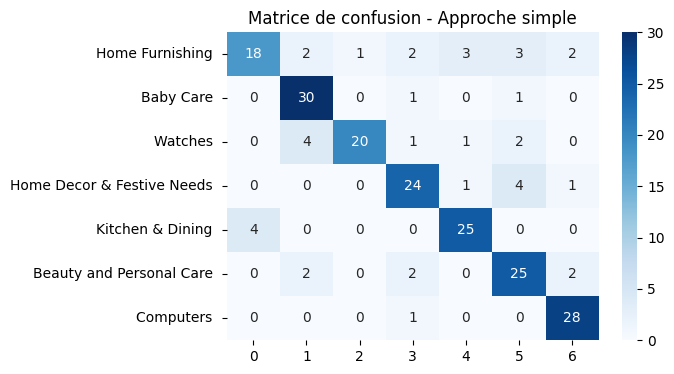

In [29]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_categories],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title('Matrice de confusion - Approche simple')

### 3. Classification supervisée par data augmentation

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### 3.1. Prétraitement des images (data augmentation)

In [31]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(df, directory='',
                                x_col='image_path', y_col='Category_Level_1',
                                weight_col=None, target_size=(224, 224),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [32]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [33]:
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(df_train, datagen_train, data_type='training')
val_flow = data_flow_fct(df_train, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(df_test, datagen_test, data_type=None)

Found 788 validated image filenames belonging to 7 classes.
Found 262 validated image filenames belonging to 7 classes.
Found 1050 validated image filenames belonging to 7 classes.


#### 3.2. Création du modèle

In [34]:
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

model2_save_path = "./model1_best_weights.keras"  
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


#### 3.3. Entraînement du modèle

In [35]:
start_time = time.time()

with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=10, callbacks=callbacks_list, verbose=1)
    
end_time = time.time()  

execution_time_2 = end_time - start_time

results_time = results_time.append({'Méthode': 'Approche Data augmentation', 'Temps exécution': execution_time_2}, ignore_index=True)


Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
2024-09-24 16:51:40.050306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:161: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-24 16:51:41.594662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.3595 - loss: 6.2403 
Epoch 1: val_loss improved from inf to 2.04214, saving model to ./model1_best_weights.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 371s 14s/step - accuracy: 0.3643 - loss: 6.1606 - val_accuracy: 0.5458 - val_loss: 2.0421
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6833 - loss: 1.4815 
Epoch 2: val_loss improved from 2.04214 to 1.32472, saving model to ./model1_best_weights.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 405s 16s/step - accuracy: 0.6836 - loss: 1.4806 - val_accuracy: 0.6450 - val_loss: 1.3247
Epoch 3/10


2024-09-24 17:04:33.663719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:161: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-24 17:04:36.710565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.7243 - loss: 1.1715 
Epoch 3: val_loss did not improve from 1.32472
25/25 ━━━━━━━━━━━━━━━━━━━━ 731s 29s/step - accuracy: 0.7249 - loss: 1.1700 - val_accuracy: 0.5496 - val_loss: 1.7068
Epoch 4/10


2024-09-24 17:16:46.242640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:161: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-24 17:16:55.626353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.7348 - loss: 0.9088 
Epoch 4: val_loss did not improve from 1.32472
25/25 ━━━━━━━━━━━━━━━━━━━━ 744s 29s/step - accuracy: 0.7360 - loss: 0.9044 - val_accuracy: 0.6260 - val_loss: 1.3458
Epoch 5/10


2024-09-24 17:29:10.565894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:161: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-24 17:29:15.116298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.7818 - loss: 0.7810 
Epoch 5: val_loss did not improve from 1.32472
25/25 ━━━━━━━━━━━━━━━━━━━━ 745s 29s/step - accuracy: 0.7828 - loss: 0.7762 - val_accuracy: 0.6183 - val_loss: 1.6000
Epoch 6/10


2024-09-24 17:41:35.878425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:161: Filling up shuffle buffer (this may take a while): 5 of 8
2024-09-24 17:41:43.159166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.8135 - loss: 0.6279 
Epoch 6: val_loss improved from 1.32472 to 1.29976, saving model to ./model1_best_weights.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 758s 30s/step - accuracy: 0.8143 - loss: 0.6255 - val_accuracy: 0.6527 - val_loss: 1.2998
Epoch 7/10


2024-09-24 17:54:15.896773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:161: Filling up shuffle buffer (this may take a while): 5 of 8
2024-09-24 17:54:22.172196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.8616 - loss: 0.4618 
Epoch 7: val_loss improved from 1.29976 to 1.29390, saving model to ./model1_best_weights.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 740s 29s/step - accuracy: 0.8612 - loss: 0.4632 - val_accuracy: 0.6870 - val_loss: 1.2939
Epoch 8/10


2024-09-24 18:06:33.048415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:161: Filling up shuffle buffer (this may take a while): 5 of 8
2024-09-24 18:06:38.359415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8872 - loss: 0.3591 
Epoch 8: val_loss did not improve from 1.29390
25/25 ━━━━━━━━━━━━━━━━━━━━ 427s 16s/step - accuracy: 0.8868 - loss: 0.3613 - val_accuracy: 0.6298 - val_loss: 1.4380
Epoch 9/10


2024-09-24 18:13:55.388419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:161: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-24 18:13:56.463937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9016 - loss: 0.3506 
Epoch 9: val_loss improved from 1.29390 to 1.26306, saving model to ./model1_best_weights.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 380s 14s/step - accuracy: 0.9008 - loss: 0.3531 - val_accuracy: 0.6908 - val_loss: 1.2631
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8953 - loss: 0.4031 
Epoch 10: val_loss improved from 1.26306 to 1.09887, saving model to ./model1_best_weights.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 367s 14s/step - accuracy: 0.8956 - loss: 0.4005 - val_accuracy: 0.7481 - val_loss: 1.0989


/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_38162/2328764137.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_time = results_time.append({'Méthode': 'Approche Data augmentation', 'Temps exécution': execution_time_2}, ignore_index=True)


#### 3.4. Scores

In [36]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

 3/25 ━━━━━━━━━━━━━━━━━━━━ 3:41 10s/step - accuracy: 0.9688 - loss: 0.0619

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 272s 11s/step - accuracy: 0.9677 - loss: 0.0924
Training Accuracy   : 0.9721

9/9 ━━━━━━━━━━━━━━━━━━━━ 92s 10s/step - accuracy: 0.7388 - loss: 1.0462
Validation Accuracy :  0.7252


In [37]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Accuracy       :  0.9067
Validation Accuracy :  0.7214


In [38]:
results_accuracy = results_accuracy.append({'Méthode': 'Approche Data augmentation', 'Accuracy': accuracy}, ignore_index=True)

/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_38162/988474036.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_accuracy = results_accuracy.append({'Méthode': 'Approche Data augmentation', 'Accuracy': accuracy}, ignore_index=True)


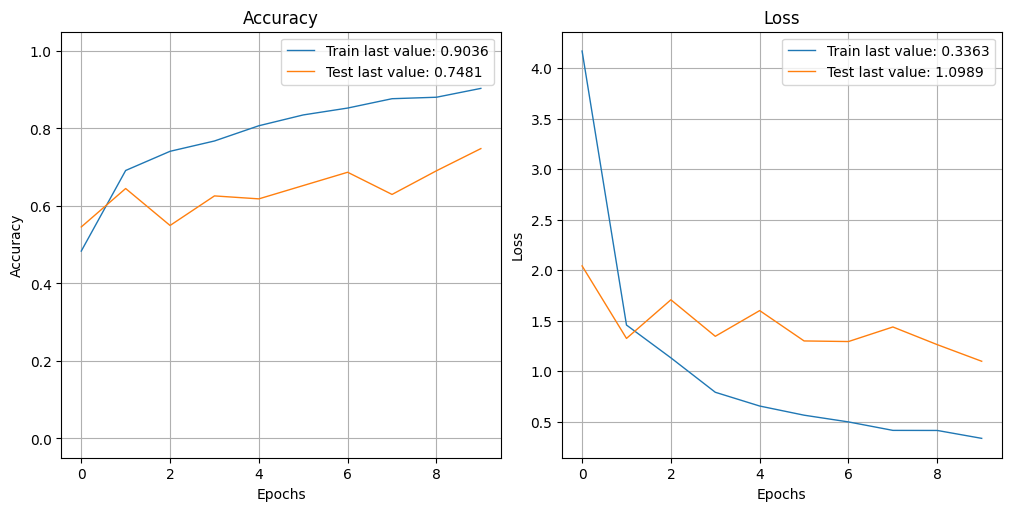

In [39]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard_2.png")
plt.close()

### 4. Approche nouvelle par Dataset sans data augmentation

#### 4.1. Prétraitement des images

In [40]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [41]:
def organize_images_by_class(df, dest_folder):
    for _, row in df.iterrows():
        class_name = str(row['label'])  
        class_folder = os.path.join(dest_folder, class_name)
        os.makedirs(class_folder, exist_ok=True)
        
        source_path = os.path.join(image_folder, row['image_path'])
        

        dest_path = os.path.join(class_folder, os.path.basename(row['image_path']))
        
        shutil.copy(source_path, dest_path)

organize_images_by_class(df_train, train_folder)
organize_images_by_class(df_test, test_folder)

print("Organisation des images terminée.")

Organisation des images terminée.


In [42]:
dataset_train = dataset_fct(train_folder, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(train_folder, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(test_folder, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


#### 4.2. Création du modèle

In [43]:
with tf.device('/gpu:0'): 
    model3 = create_model_fct()

model3_save_path = "./model3_best_weights.keras"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


#### 4.3. Entraînement du modèle

In [44]:
start_time = time.time()

with tf.device('/gpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=10, callbacks=callbacks_list, verbose=1)
    

end_time = time.time()  

execution_time_3 = end_time - start_time

results_time = results_time.append({'Méthode': 'Approche nouvelle sans data augmentation', 'Temps exécution': execution_time_3}, ignore_index=True)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3309 - loss: 9.2967 
Epoch 1: val_loss improved from inf to 2.17947, saving model to ./model3_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 286s 14s/step - accuracy: 0.3367 - loss: 9.1509 - val_accuracy: 0.7143 - val_loss: 2.1795
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6620 - loss: 2.5873 
Epoch 2: val_loss improved from 2.17947 to 1.60497, saving model to ./model3_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 281s 14s/step - accuracy: 0.6631 - loss: 2.5706 - val_accuracy: 0.7333 - val_loss: 1.6050
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7540 - loss: 1.3991 
Epoch 3: val_loss improved from 1.60497 to 1.53100, saving model to ./model3_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 281s 14s/step - accuracy: 0.7539 - loss: 1.3972 - val_accuracy: 0.6857 - val_loss: 1.5310
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7954 - loss: 0.8491 
Epoch 4: val_loss improve

/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_38162/1592921891.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_time = results_time.append({'Méthode': 'Approche nouvelle sans data augmentation', 'Temps exécution': execution_time_3}, ignore_index=True)


#### 4.4. Scores

In [45]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 204s 10s/step - accuracy: 0.9974 - loss: 0.0213
Training Accuracy   : 0.9952

7/7 ━━━━━━━━━━━━━━━━━━━━ 78s 11s/step - accuracy: 0.7913 - loss: 1.1979
Validation Accuracy :  0.7905


In [46]:
# Score de l'epoch optimal
model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

Test Accuracy       :  0.8095
Validation Accuracy :  0.8048


In [47]:
results_accuracy = results_accuracy.append({'Méthode': 'Approche nouvelle sans data augmentation', 'Accuracy': accuracy}, ignore_index=True)

/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_38162/4293104591.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_accuracy = results_accuracy.append({'Méthode': 'Approche nouvelle sans data augmentation', 'Accuracy': accuracy}, ignore_index=True)


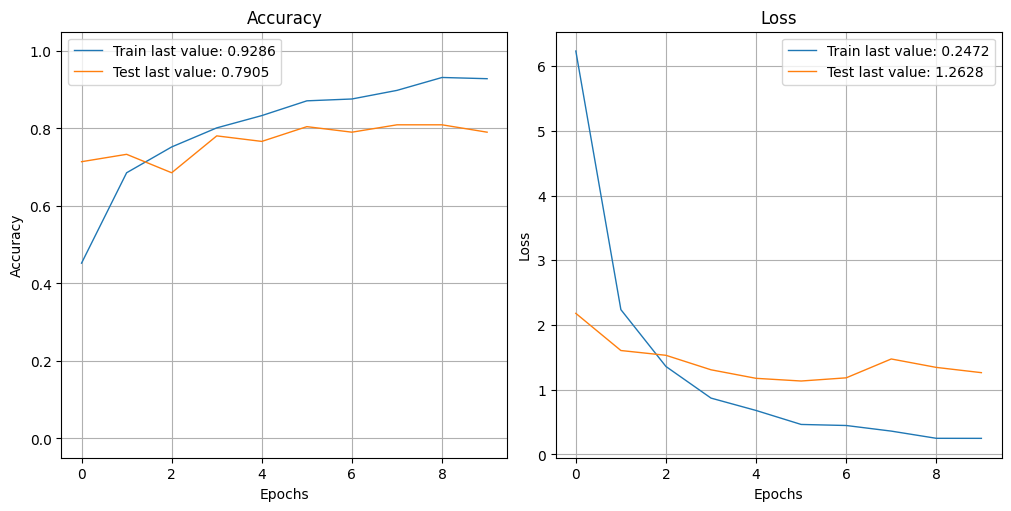

In [48]:
show_history(history3)
plot_history(history3, path="standard_3.png")
plt.close()

### 5. Approche nouvelle par Dataset avec data augmentation intégrée au modèle

#### 5.1. Prétraitement des images

In [49]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [50]:
dataset_train = dataset_fct(train_folder, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(train_folder, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(test_folder, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [51]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [52]:
def create_model_fct2() :
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1)
      ])
    
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

#### 5.2. Création du modèle

In [53]:
with tf.device('/gpu:0'): 
    model4 = create_model_fct2()

model4_save_path = "./model4_best_weights.keras"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


#### 5.3. Entraînement du modèle

In [54]:
start_time = time.time()

with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=10, callbacks=callbacks_list, verbose=1)


end_time = time.time()  

execution_time_4 = end_time - start_time

results_time = results_time.append({'Méthode': 'Approche nouvelle avec data augmentation', 'Temps exécution': execution_time_4}, ignore_index=True)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.2044 - loss: 2.0731 
Epoch 1: val_loss improved from inf to 1.46908, saving model to ./model4_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 311s 15s/step - accuracy: 0.2070 - loss: 2.0669 - val_accuracy: 0.5762 - val_loss: 1.4691
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.4593 - loss: 1.5528 
Epoch 2: val_loss improved from 1.46908 to 1.17425, saving model to ./model4_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 299s 15s/step - accuracy: 0.4613 - loss: 1.5486 - val_accuracy: 0.6524 - val_loss: 1.1743
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5886 - loss: 1.2981 
Epoch 3: val_loss improved from 1.17425 to 1.03547, saving model to ./model4_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 279s 14s/step - accuracy: 0.5904 - loss: 1.2940 - val_accuracy: 0.7000 - val_loss: 1.0355
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6278 - loss: 1.0993 
Epoch 4: val_loss improve

/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_38162/2093770754.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_time = results_time.append({'Méthode': 'Approche nouvelle avec data augmentation', 'Temps exécution': execution_time_4}, ignore_index=True)


#### 5.4. Scores

In [55]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 189s 9s/step - accuracy: 0.7961 - loss: 0.5709
Training Accuracy   : 0.7889

7/7 ━━━━━━━━━━━━━━━━━━━━ 63s 9s/step - accuracy: 0.7549 - loss: 0.7450
Validation Accuracy :  0.7619


In [56]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

Test Accuracy       :  0.7762
Validation Accuracy :  0.7762


In [57]:
results_accuracy = results_accuracy.append({'Méthode': 'Approche nouvelle avec data augmentation', 'Accuracy': accuracy}, ignore_index=True)

/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_38162/348897200.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_accuracy = results_accuracy.append({'Méthode': 'Approche nouvelle avec data augmentation', 'Accuracy': accuracy}, ignore_index=True)


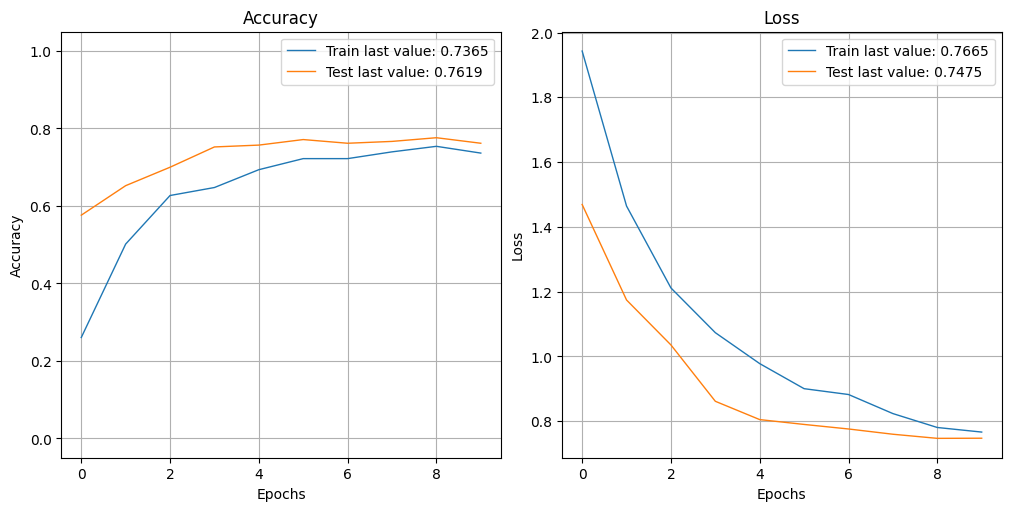

In [58]:
show_history(history4)
plot_history(history4, path="standard_4.png")
plt.close()

### 6. Conclusion

In [59]:
results = pd.merge(results_accuracy, results_time, on='Méthode', how='inner')
results['Accuracy'] = results['Accuracy'].round(3)
results = results.rename(columns={'Temps exécution': 'Temps exécution (min)'})
results['Temps exécution (min)'] = results['Temps exécution (min)'] / 60
results['Temps exécution (min)'] = results['Temps exécution (min)'].round(2)


results

,Méthode,Accuracy,Temps exécution (min)
0,Approche simple,0.810,45.82
1,Approche Data augmentation,0.721,94.52
2,Approche nouvelle sans data augmentation,0.805,48.16
3,Approche nouvelle avec data augmentation,0.776,48.12


- L'approche simple (sans data augmentation) obtient la meilleure précision avec 0.810, ce qui signifie qu'elle classe correctement 81 % des images.
- L'approche nouvelle sans data augmentation suit de près avec une précision de 0.805, ce qui est presque équivalent à l'approche simple. Cela suggère que cette nouvelle approche est compétitive en termes de performance.
- L'approche Data augmentation et l'approche nouvelle avec data augmentation affichent des performances plus faibles avec des précisions de 0.721 et 0.776 respectivement. L'augmentation de données semble diminuer légèrement l'efficacité du modèle.

La data augmentation est généralement utilisée pour améliorer la robustesse du modèle en augmentant la diversité des données d'entraînement. Cependant, dans ce cas, les résultats montrent que la data augmentation diminue légèrement la performance en termes d'accuracy. Cela pourrait indiquer que l'augmentation des données a introduit du bruit ou des variations trop importantes qui ont rendu la tâche plus difficile pour le modèle.
Les approches sans data augmentation offrent de meilleures performances immédiates en termes de précision. Cela peut signifier que les données d'origine étaient suffisamment représentatives pour entraîner un modèle performant sans nécessiter d'augmentation